### Imports

In [1]:
import shutil
import importlib
import cv2
shutil.rmtree('__pycache__')
import Player
importlib.reload(Player)
from Player import get_player_boxes
from Ball import BallDetector
import detect_court_net
import Transmit
import matplotlib.pyplot as plt
import numpy as np
import random

read the video by the videostream class

In [2]:
path_to_video = 'cocog.mp4'

In [3]:
vs = Transmit.VideoStream()
frames = vs.read_video(path_to_video)

load the balls and initiate the ball detector

In [4]:
bd = BallDetector(path_weights='weights/model.3')



layer24 output shape: 256 360 640
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 360, 640)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 360, 640)      5248      
                                                                 
 activation (Activation)     (None, 64, 360, 640)      0         
                                                                 
 batch_normalization (Batch  (None, 64, 360, 640)      2560      
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 360, 640)      36928     
                                                                 
 activation_1 (Activation)   (None, 64, 360, 640)      0         
                       

setting the resolution of video

In [5]:
bd.output_height = vs.output_height
bd.output_width = vs.output_width

detect balls

In [6]:
ballpoints = bd.find_ball_points(frames)
ballpoints = bd.postprocess_points(ballpoints)
# bd.draw_trajectory_pride(frames, ballpoints, 'balltestonly.mp4') #if you need to only see the balls

1/1 [==============================] - 1s 1s/step


find players

In [7]:
players = Player.get_player_boxes(frames)

just see the transmitted version

In [8]:
courtpoints = detect_court_net.detect_points(frames[1], False)
# img = detect_court_net.detect_points(frames[1], True)
# print(courtpoints, frames[0].shape, len(frames))
print(courtpoints)

([[373, 147], [373, 218], [374, 698], [374, 628], [276, 256], [277, 424], [278, 592], [114, 287], [113, 321], [112, 565], [112, 529], [147, 307], [148, 425], [148, 543], [169, 425]], [[166, 255], [166, 595]])


In [9]:
print(len(players), len(ballpoints), len(frames), frames[0].shape)
print(players[0], ballpoints[0], courtpoints)

192 193 193 (480, 854, 3)
[(335, 292, 40, 62), (506, 64, 25, 40)] [375, 295] ([[373, 147], [373, 218], [374, 698], [374, 628], [276, 256], [277, 424], [278, 592], [114, 287], [113, 321], [112, 565], [112, 529], [147, 307], [148, 425], [148, 543], [169, 425]], [[166, 255], [166, 595]])


In [10]:
while len(players) != len(frames):
    players.insert(0, [])

In [11]:
print(path_to_video, frames[0].shape)

cocog.mp4 (480, 854, 3)


In [12]:
cap = cv2.VideoCapture(path_to_video) 
fourcc = cv2.VideoWriter_fourcc('H','2','6','4')
out = cv2.VideoWriter("gg_ff_out.mp4", fourcc, cap.get(cv2.CAP_PROP_FPS), (frames[0].shape[1],frames[0].shape[0]))
for i, frame in enumerate(frames):
    for bbox in players[i]:
        Player.drawBox(frame, bbox)
    # print(i, ballpoints[i][0])
    Player.drawBox(frame, (ballpoints[i][0], ballpoints[i][1], 10, 10))
    keypoints, netpoints = courtpoints
    for point in keypoints + netpoints:
        Player.drawBox(frame, (point[1], point[0], 10, 10))
    
    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()

[[373, 147], [373, 218], [374, 698], [374, 628], [276, 256], [277, 424], [278, 592], [114, 287], [113, 321], [112, 565], [112, 529], [147, 307], [148, 425], [148, 543], [169, 425], [166, 255], [166, 595]] 17


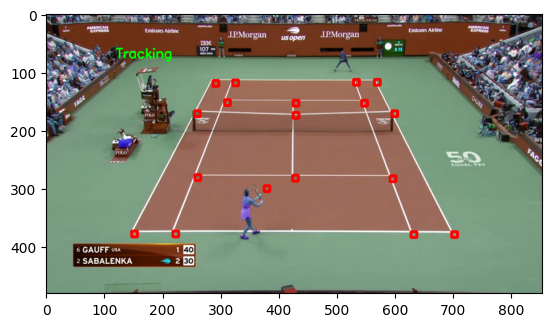

In [13]:
plt.imshow(frames[0])
all_courtpoints = courtpoints[0] + courtpoints[1]
print(all_courtpoints, len(all_courtpoints))

In [15]:
path_2d_court = 'tennis_2d_3.png'

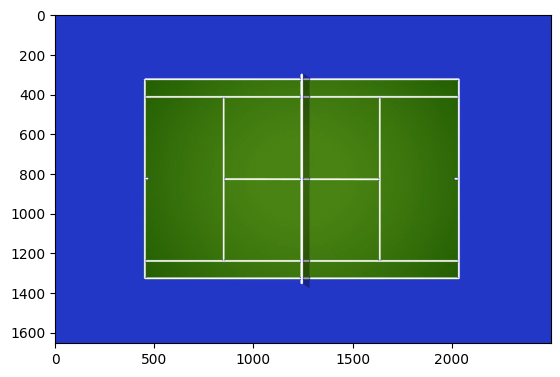

In [16]:
img = cv2.imread(path_2d_court)
plt.imshow(img[:,:,::-1])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
img[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(img)
# print((dst>0.01*dst.max()).shape)
kpts = np.argwhere(dst>0.01*dst.max())
# print(len(kpts))

In [17]:
# all_court2dpoints = [[67, 63] , [138, 63] , [545, 63], [474, 63] , [138, 288], [306, 288],
#                  [474, 288] , [67, 960], [138, 960], [545, 960], [474, 960], [138, 738],
#                  [306, 738] , [474, 738], [306, 512], [67, 512], [545 , 512]]
# all_court2dpoints = [[74, 61] , [106, 61] , [324, 61], [287, 61] , [106, 148], [199, 148],
                 # [287, 148] , [74, 549], [106, 549], [324, 549], [287, 549], [106, 462],
                 # [199, 462] , [287, 462], [199, 306], [74, 306], [324 , 306]]
all_court2dpoints = [[327, 453] , [416, 453] , [1329, 453], [1241, 453] , [416, 851], [830, 851],
                 [1241, 851] , [327, 2034], [416, 2034], [1329, 2034], [1241, 2034], [416, 1638],
                 [830, 1638] , [1241, 1638], [830, 1244], [327, 1244], [1329 , 1244]]

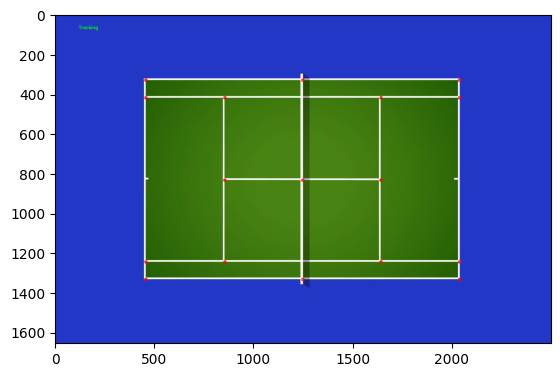

In [18]:
img = cv2.imread(path_2d_court)
for pt in all_court2dpoints:
    Player.drawBox(img, (pt[1], pt[0], 10, 10))
plt.imshow(img)

In [19]:
np_all_courtpoints = np.array(all_courtpoints)
np_all_court2dpoints = np.array(all_court2dpoints)

# zipped_points = list(zip(all_courtpoints, all_court2dpoints))
# random.shuffle(zipped_points)
# np_all_courtpoints, np_all_court2dpoints = zip(*zipped_points)
# np_all_courtpoints = np.array(np_all_courtpoints)
# np_all_court2dpoints = np.array(np_all_court2dpoints)

# np_all_court2dpoints[:,1] -= 30

H, _ = cv2.findHomography(np_all_courtpoints, np_all_court2dpoints)
print(H)

[[ 1.06947279e+01  1.01598820e+01 -3.45392220e+03]
 [-8.78907381e+00  1.59250927e-01  5.90594173e+03]
 [ 1.27279089e-02  1.48978263e-04  1.00000000e+00]]


In [20]:
error = 0
for i,p in enumerate(all_courtpoints):
    pp = H @ [p[0], p[1], 1]
    pp /= pp[-1]
    print(pp[:2], all_court2dpoints[i], pp[:2] - all_court2dpoints[i])
    error +=  np.sum((pp[:2] - all_court2dpoints[i])**2)
print(error**0.5)

[351.63283887 459.49710084] [327, 453] [24.63283887  6.49710084]
[475.79093988 460.61241561] [416, 453] [59.79093988  7.61241561]
[1302.3893203   465.53216984] [1329, 453] [-26.6106797   12.53216984]
[1183.21711619  464.45717979] [1241, 453] [-57.78288381  11.45717979]
[461.15874603 773.65274752] [416, 851] [ 45.15874603 -77.34725248]
[831.65739332 771.20218179] [830, 851] [  1.65739332 -79.79781821]
[1196.10892963  768.79161309] [1241, 851] [-44.89107037 -82.20838691]
[ 273.14931274 1984.84828382] [327, 2034] [-53.85068726 -49.15171618]
[ 408.63766696 1996.67929873] [416, 2034] [ -7.36233304 -37.32070127]
[1388.30248194 1996.870226  ] [1329, 2034] [ 59.30248194 -37.129774  ]
[1245.22659829 1998.85742631] [1241, 2034] [  4.22659829 -35.14257369]
[ 424.20203244 1598.64767563] [416, 1638] [  8.20203244 -39.35232437]
[ 830.27111304 1585.60131476] [830, 1638] [  0.27111304 -52.39868524]
[1229.73819563 1582.53773551] [1241, 1638] [-11.26180437 -55.46226449]
[ 831.10157118 1396.33037087] [83

In [23]:
img = cv2.imread(path_2d_court)
cap = cv2.VideoCapture(path_to_video) 
fourcc = cv2.VideoWriter_fourcc('H','2','6','4')
out = cv2.VideoWriter("homography_map.mp4", fourcc, cap.get(cv2.CAP_PROP_FPS), (img.shape[1], img.shape[0]))
for i in range(len(frames)):
    frame = img.copy()
    # print(players[i])
    for x, y, w, h in players[i]:
        x_middle = x + w // 2
        y_middle = y + h // 2
        point_h = H @ [y_middle, x_middle, 1]
        point_h = point_h / point_h[-1]
        # print(point_h)
        cv2.circle(frame, center=(round(point_h[1]), round(point_h[0])), radius=25, color=(0, 255, 0), thickness=-1)
    # print(i, ballpoints[i][0])
    ball_h = H @ [ballpoints[i][1], ballpoints[i][0], 1]
    ball_h = ball_h / ball_h[-1]
    cv2.circle(frame, center=(round(ball_h[1]), round(ball_h[0])), radius=10, color=(255, 0, 0), thickness=-1)    
    out.write(frame)
    # print('yooooooooooo')

cap.release()
out.release()
cv2.destroyAllWindows()